In [25]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [26]:
def factor_function(sigma_i, sigma_j, j_neighbour, j_neighbour2, permutation, d):
    final = 1
    first_neighbours = [sigma_j, permutation[0], permutation[3]]
    second_neighbours = [[j_neighbour, j_neighbour2],list(permutation[1:3]),list(permutation[4:6])]
    for idx, j in enumerate(first_neighbours):
        if j==1:
            total = sigma_i + np.sum(first_neighbours) - 1
            for idx2, neighbours in enumerate(second_neighbours):
                if idx2 != idx:
                    total += np.sum(neighbours)
            if total == 0:
                final *= 1
            else:
                final *= 0
        if final == 0:
            return 0
    return final

In [27]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.8, verbose=0, init_psi=None):
    psi=np.zeros((2, 2, 2, 2))
    if init_psi is None:
        psi=np.random.uniform(size=(2, 2, 2, 2))
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=np.array(list(itertools.product([0,1], repeat=6)))
    
    for t in range(max_iter):
        psi_new=np.zeros((2, 2, 2, 2))
        for i in range(2):
            for j in range(2):
                for j_neighbour in range(2):
                    for j_neighbour2 in range(2):
                        for perm in permutations:
                            mult=1
                            if factor_function(i, j, j_neighbour, j_neighbour2, perm, d)==0:
                                continue
                            #for _ in range(2): #mudar para degree
                            mult*=psi[i, perm[0], perm[1], perm[2]]
                            mult*=psi[i, perm[3], perm[4], perm[5]]
                            psi_new[i, j, j_neighbour, j_neighbour2]+=np.exp(mu*i)*mult
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.ones((2, 2, 2, 2, 2, 2))/64
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [28]:
psi = BP(3, mu=3, verbose=0)

In [29]:
print(psi)

[[[[9.45504293e-13 5.72882819e-13]
   [5.49482287e-13 3.32285982e-13]]

  [[1.36899562e-13 7.92234819e-13]
   [7.22181735e-13 3.39078315e-13]]]


 [[[2.50000000e-01 2.50000000e-01]
   [2.50000000e-01 2.50000000e-01]]

  [[7.85639972e-13 5.25749943e-13]
   [1.63368811e-13 3.67327143e-15]]]]


In [33]:
def update_observables(psi, mu, d=3):
        phi_=0
        phi__=0

        permutations=np.array(list(itertools.product([0,1], repeat=6)))
        
        numerator=0
        
        for i in range(2):
            for j in range(2):
                for j_neighbour in range(2):
                    for j_neighbour2 in range(2):
                        for perm in permutations:
                            mult=1
                            if factor_function(i, j, j_neighbour, j_neighbour2, perm, d)==0:
                                continue
                            mult*=psi[i, perm[0], perm[1], perm[2]]
                            mult*=psi[i, perm[3], perm[4], perm[5]]
                            mult*=psi[i, j, j_neighbour, j_neighbour2]
                            phi_+=mult*np.exp(mu*i)
                            numerator+=i*mult*np.exp(mu*i)
                            
                        phi__+=psi[i, j, j_neighbour, j_neighbour2]*psi[j, i, perm[0], perm[3]]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

In [34]:
mu_space = np.linspace(0, 7, 50)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in tqdm(mu_space):
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

100%|██████████| 50/50 [00:40<00:00,  1.25it/s]


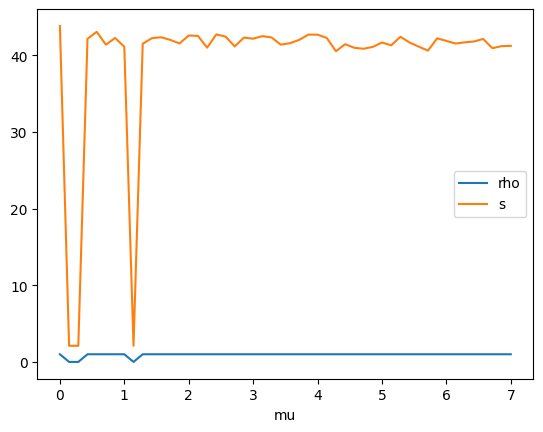

In [35]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()